In [181]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

In [182]:
df = pd.read_csv("../data/Coffee Shop Sales.csv")
df.tail()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
149111,149452,30-06-2023,20:18:41,2,8,Hell's Kitchen,44,2.50,Tea,Brewed herbal tea,Peppermint Rg
149112,149453,30-06-2023,20:25:10,2,8,Hell's Kitchen,49,3.00,Tea,Brewed Black tea,English Breakfast Lg
149113,149454,30-06-2023,20:31:34,1,8,Hell's Kitchen,45,3.00,Tea,Brewed herbal tea,Peppermint Lg
149114,149455,30-06-2023,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino
149115,149456,30-06-2023,20:57:19,2,8,Hell's Kitchen,64,0.80,Flavours,Regular syrup,Hazelnut syrup


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_id    149116 non-null  int64  
 1   transaction_date  149116 non-null  object 
 2   transaction_time  149116 non-null  object 
 3   transaction_qty   149116 non-null  int64  
 4   store_id          149116 non-null  int64  
 5   store_location    149116 non-null  object 
 6   product_id        149116 non-null  int64  
 7   unit_price        149116 non-null  float64
 8   product_category  149116 non-null  object 
 9   product_type      149116 non-null  object 
 10  product_detail    149116 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 12.5+ MB


In [184]:
# Calculate total sales for each transaction
df['total_sales'] = df['transaction_qty'] * df['unit_price']

# Convert transaction_date to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='%d-%m-%Y')

# Aggregate sales by day
daily_sales = df.groupby('transaction_date')['total_sales'].sum().reset_index()
daily_sales = daily_sales.set_index('transaction_date')

# Display the processed data
print(daily_sales.head())

                  total_sales
transaction_date             
2023-01-01            2508.20
2023-01-02            2403.35
2023-01-03            2565.00
2023-01-04            2220.10
2023-01-05            2418.85


In [ ]:
# Create time-based features
def create_features(df):
    df = df.copy()
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week
    return df

daily_sales = create_features(daily_sales)

In [186]:
daily_sales.head()

,total_sales,day,month,quarter,day_of_week,day_of_year,week_of_year
transaction_date,,,,,,,
2023-01-01,2508.20,1,1,1,6,1,52
2023-01-02,2403.35,2,1,1,0,2,1
2023-01-03,2565.00,3,1,1,1,3,1
2023-01-04,2220.10,4,1,1,2,4,1
2023-01-05,2418.85,5,1,1,3,5,1


In [187]:
daily_sales.tail()

,total_sales,day,month,quarter,day_of_week,day_of_year,week_of_year
transaction_date,,,,,,,
2023-06-26,5875.90,26,6,2,0,177,26
2023-06-27,5975.65,27,6,2,1,178,26
2023-06-28,4728.90,28,6,2,2,179,26
2023-06-29,4450.75,29,6,2,3,180,26
2023-06-30,5481.32,30,6,2,4,181,26


In [188]:
# Split into train and test sets (last 7 days for testing)
train = daily_sales.iloc[:-7]
test = daily_sales.iloc[-7:]

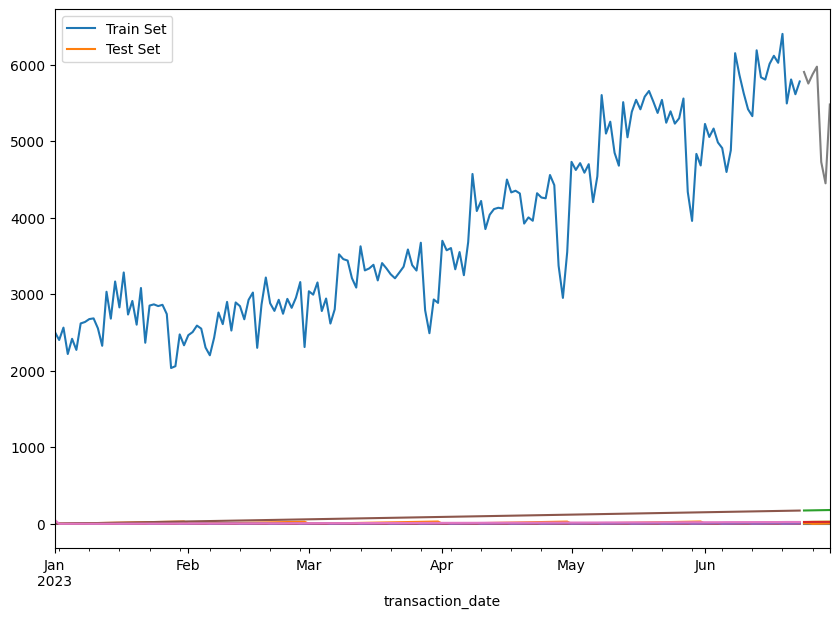

In [189]:
fig, ax = plt.subplots(figsize=(10, 7))
train.plot(ax=ax, label="Training Set")
test.plot(ax=ax, label="Test Set")
ax.legend(["Train Set", "Test Set"])
plt.show()

In [190]:
# Split into train and test sets (last 7 days for testing)
train = daily_sales.iloc[:-7]
test = daily_sales.iloc[-7:]

# Define features and target
FEATURES = ['day', 'month', 'day_of_week', 'week_of_year', 'day_of_year']
TARGET = 'total_sales'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [191]:
train

,total_sales,day,month,quarter,day_of_week,day_of_year,week_of_year
transaction_date,,,,,,,
2023-01-01,2508.20,1,1,1,6,1,52
2023-01-02,2403.35,2,1,1,0,2,1
2023-01-03,2565.00,3,1,1,1,3,1
2023-01-04,2220.10,4,1,1,2,4,1
2023-01-05,2418.85,5,1,1,3,5,1
...,...,...,...,...,...,...,...
2023-06-19,6403.91,19,6,2,0,170,25
2023-06-20,5494.66,20,6,2,1,171,25
2023-06-21,5808.38,21,6,2,2,172,25


In [192]:
test

,total_sales,day,month,quarter,day_of_week,day_of_year,week_of_year
transaction_date,,,,,,,
2023-06-24,5906.10,24,6,2,5,175,25
2023-06-25,5754.85,25,6,2,6,176,25
2023-06-26,5875.90,26,6,2,0,177,26
2023-06-27,5975.65,27,6,2,1,178,26
2023-06-28,4728.90,28,6,2,2,179,26
2023-06-29,4450.75,29,6,2,3,180,26
2023-06-30,5481.32,30,6,2,4,181,26


In [193]:
X_train.shape, X_test.shape

((174, 5), (7, 5))

In [194]:
# Initialize and train the model
model = XGBRegressor(n_estimators=4000, 
                    early_stopping_rounds=50,
                    learning_rate=0.03)

model.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)],
         verbose=100)

[0]	validation_0-rmse:1126.02207	validation_1-rmse:1712.13071
[100]	validation_0-rmse:134.79445	validation_1-rmse:372.13648
[200]	validation_0-rmse:62.77490	validation_1-rmse:356.83324
[300]	validation_0-rmse:39.68545	validation_1-rmse:345.08267
[400]	validation_0-rmse:26.30881	validation_1-rmse:337.39490
[500]	validation_0-rmse:18.39204	validation_1-rmse:336.01794
[600]	validation_0-rmse:14.11754	validation_1-rmse:333.51867
[700]	validation_0-rmse:10.62850	validation_1-rmse:332.90928
[800]	validation_0-rmse:8.06292	validation_1-rmse:332.48404
[900]	validation_0-rmse:6.08243	validation_1-rmse:331.34961
[1000]	validation_0-rmse:4.30182	validation_1-rmse:330.35966
[1100]	validation_0-rmse:3.28166	validation_1-rmse:330.23439
[1200]	validation_0-rmse:2.69004	validation_1-rmse:330.15758
[1300]	validation_0-rmse:2.17474	validation_1-rmse:329.81820
[1400]	validation_0-rmse:1.74663	validation_1-rmse:329.71908
[1500]	validation_0-rmse:1.32452	validation_1-rmse:329.67546
[1538]	validation_0-rmse

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=4000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [195]:
fi = pd.DataFrame(data=model.feature_importances_,
             index = model.feature_names_in_,
             columns=['importance'])

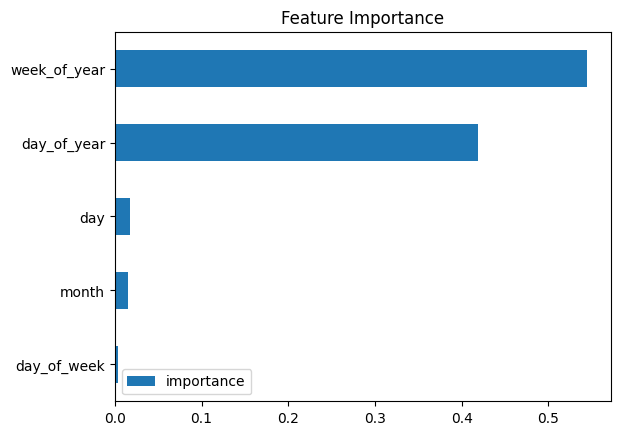

In [196]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [197]:
# Make predictions
test['prediction'] = model.predict(X_test)
daily_sales = daily_sales.merge(test[['prediction']], how='left', left_index=True, right_index=True)

C:\Users\dp971\AppData\Local\Temp\ipykernel_25164\1707430979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(X_test)


In [198]:
test

,total_sales,day,month,quarter,day_of_week,day_of_year,week_of_year,prediction
transaction_date,,,,,,,,
2023-06-24,5906.10,24,6,2,5,175,25,5828.068359
2023-06-25,5754.85,25,6,2,6,176,25,5711.759277
2023-06-26,5875.90,26,6,2,0,177,26,5772.657227
2023-06-27,5975.65,27,6,2,1,178,26,5692.280273
2023-06-28,4728.90,28,6,2,2,179,26,5152.428711
2023-06-29,4450.75,29,6,2,3,180,26,5107.344727
2023-06-30,5481.32,30,6,2,4,181,26,5254.596680


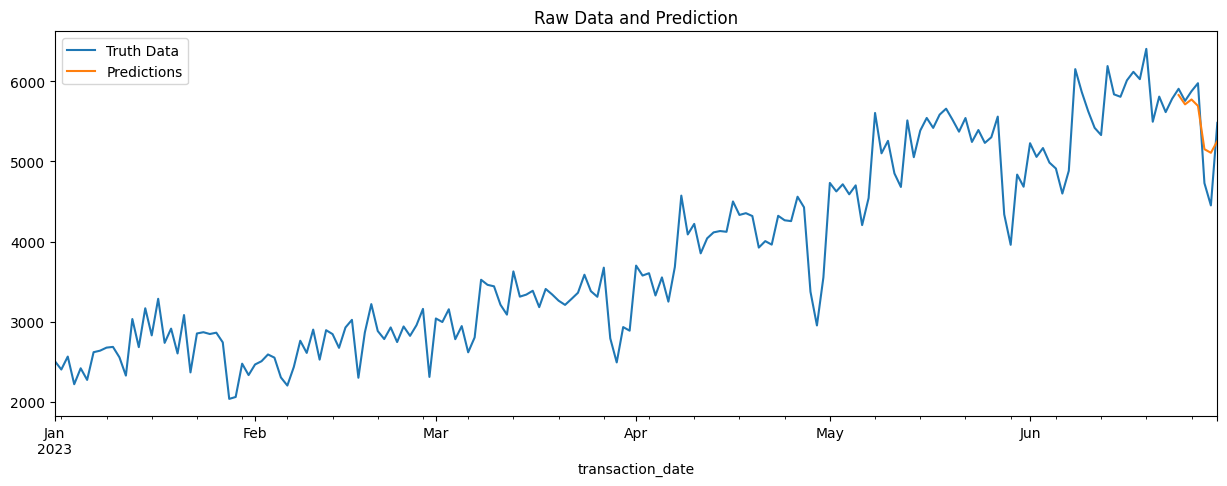

In [199]:
ax = daily_sales[["total_sales"]].plot(figsize=(15, 5))
daily_sales['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [200]:
y_train

transaction_date
2023-01-01    2508.20
2023-01-02    2403.35
2023-01-03    2565.00
2023-01-04    2220.10
2023-01-05    2418.85
               ...   
2023-06-19    6403.91
2023-06-20    5494.66
2023-06-21    5808.38
2023-06-22    5615.10
2023-06-23    5781.86
Name: total_sales, Length: 174, dtype: float64

In [201]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, mean_absolute_percentage_error

r2 = r2_score(test['total_sales'], test['prediction'])
mape = mean_absolute_percentage_error(test['total_sales'], test['prediction'])

# Display results..
evaluation_metrics = {
    "R-squared (R2)": r2,
    "mape": mape
}

evaluation_metrics

{'R-squared (R2)': 0.6660298385694035, 'mape': 0.0520200355142981}

Empty DataFrame
Columns: []
Index: [2023-07-01 00:00:00, 2023-07-02 00:00:00, 2023-07-03 00:00:00, 2023-07-04 00:00:00, 2023-07-05 00:00:00, 2023-07-06 00:00:00, 2023-07-07 00:00:00]


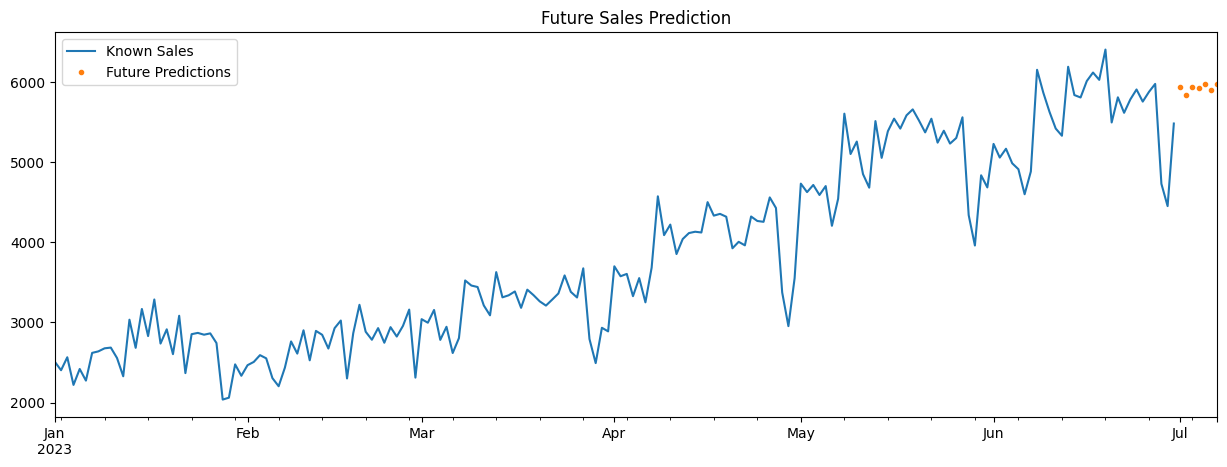

In [202]:
# Create future dataframe
future = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
future_df = pd.DataFrame(index=future)
print(future_df)
future_df['isFuture'] = True
daily_sales['isFuture'] = False

df_and_future = pd.concat([daily_sales, future_df])
df_and_future = create_features(df_and_future)
df_and_future['pred'] = model.predict(df_and_future[FEATURES])

# Plot future predictions
ax = df_and_future[df_and_future['isFuture']==False][['total_sales']].plot(figsize=(15, 5))
df_and_future[df_and_future['isFuture']==True]['pred'].plot(ax=ax, style='.')
plt.legend(['Known Sales', 'Future Predictions'])
plt.title('Future Sales Prediction')
plt.show()

In [205]:
df_and_future['pred']

2023-01-01    2508.351562
2023-01-02    2403.565674
2023-01-03    2563.964844
2023-01-04    2221.298828
2023-01-05    2417.878662
                 ...     
2023-07-03    5940.424805
2023-07-04    5928.956055
2023-07-05    5974.317383
2023-07-06    5893.950195
2023-07-07    5972.558105
Name: pred, Length: 188, dtype: float32